# Predicting housing prices in Ames, Iowa

Data from 2006-2010
Why data was collected: <a href='https://doi.org/10.1080/10691898.2011.11889627'>here</a>

Column information: <a href='https://s3.amazonaws.com/dq-content/307/data_description.txt'>here</a>

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from pandas.api.types import CategoricalDtype
import seaborn as sns
%matplotlib inline

pd.options.display.max_columns = 1000
pd.options.display.max_rows = 100

In [46]:
data = pd.read_csv('AmesHousing.tsv', sep='\t')

In [47]:
# helper functions

def transform_numeric_features(data):
    data = data.copy()
    numeric_data = data.select_dtypes(include=np.number)
    threshold = int(0.25 * data.shape[0])
    missing_values = numeric_data.isna().sum()
    cols_to_drop = missing_values[missing_values > threshold].index
    numeric_data = numeric_data.drop(cols_to_drop, axis=1)

    numeric_data = numeric_data.fillna(numeric_data.mean())
    numeric_data['years_until_remod'] = numeric_data['Year Remod/Add'] - numeric_data['Year Built']
    numeric_data['years_until_sale'] = numeric_data['Yr Sold'] - numeric_data['Year Built']
    numeric_data.drop(['Year Built','Yr Sold',"Mo Sold"],axis=1)
    
    return numeric_data

def transform_text_features(data):
    data = data.copy()
    data['MS SubClass'] = data['MS SubClass'].astype('object')
    data['Mo Sold'] = data['Mo Sold'].astype('object')

    text_data = data.select_dtypes(include='object')
    text_data = text_data.fillna('No')
    
    cols_to_drop = ['']
    
    
    #Ordering ordinal variables
    ordinals = ['Utilities','Land Slope','BsmtFin Type 1','Functional',
               'Garage Finish','Fence', 'Paved Drive']
    utilities = CategoricalDtype(['ELO', 'NoSeWa', 'NoSewr','AllPub'],
                                ordered = True)
    no_to_excellent = CategoricalDtype(['No','Po','Fa','TA','Gd','Ex'], 
                                       ordered=True)
    land_slope = CategoricalDtype(['Sev','Mod','Gtl'], ordered=True)
    bmst_fin = CategoricalDtype(['No','Unf','LwQ','Rec','BLQ','ALQ','GLQ'],
                                ordered=True)
    functional = CategoricalDtype(['Sal','Sev','Maj2','Maj1','Mod',
                                  'Min2','Min1','Typ'],ordered=True)
    garage = CategoricalDtype(['No','Unf','RFn','Fin'],ordered=True)
    fence = CategoricalDtype(['No','MnWw','GdWo','MnPrv','GdPrv'],
                             ordered=True)
    paved = CategoricalDtype(['N','P','Y'], ordered=True)
    bsmt_exposure = CategoricalDtype(['Gd','Av','Mn','No','None'], 
                                     ordered=True)
    
    no_to_excellent_ordinals = ['Exter Qual', 'Exter Cond','Bsmt Qual',
                                'Bsmt Cond','Heating QC',
                                'Kitchen Qual','Garage Qual','Garage Cond',
                                'Pool QC','Fireplace Qu']
    ordinals = ordinals + no_to_excellent_ordinals
    
    for each in no_to_excellent_ordinals:
        text_data[each] = text_data[each].astype(no_to_excellent)
        
    text_data['Utilities'] = text_data['Utilities'].astype(utilities)
    text_data['Land Slope'] = text_data['Land Slope'].astype(land_slope)
    text_data['BsmtFin Type 1'] = text_data['BsmtFin Type 1'].astype(bmst_fin)
    text_data['Functional'] = text_data['Functional'].astype(functional)
    text_data['Garage Finish'] = text_data['Garage Finish'].astype(garage)
    text_data['Fence'] = text_data['Fence'].astype(fence)
    text_data['Paved Drive'] = text_data['Paved Drive'].astype(paved)
    text_data['Bsmt Exposure'] = text_data['Bsmt Exposure'].astype(bsmt_exposure)


    nominals = ['MS SubClass','MS Zoning','Street','Alley','Lot Shape',
               'Land Contour','Lot Config','Neighborhood',
               'Condition 1','Bldg Type','House Style','Roof Style',
               'Roof Matl','Exterior 1st','Foundation',
               'Heating','Central Air','Garage Type','Misc Feature',
               'Sale Type','Sale Condition', 'Mo Sold','Electrical']
    
    all_text = ordinals + nominals
    text_data = text_data[all_text]
    
    for each in nominals:
        dummy_cols = pd.get_dummies(text_data[each],prefix=each)
        text_data = pd.concat([text_data,dummy_cols],axis=1)
        text_data = text_data.drop(each,axis=1)
    return text_data

def select_features(data):
    return data

def train_and_test(data, k = 0):
    data_numeric = data.select_dtypes(include=np.number)
    features = data_numeric.columns.drop('SalePrice')
    lr = LinearRegression()
    
    if k == 0:
        train = data_numeric.iloc[:1460]
        test = data_numeric.iloc[1460:]
        
        lr = lr.fit(train[features], train['SalePrice'])
        predictions = lr.predict(test[features])
        rmse = mean_squared_error(predictions, test['SalePrice'])**0.5
        return rmse
        

    elif k == 1:
        shuffled = data_numeric.sample(frac=1)
        fold_one = data_numeric.iloc[:1460]
        fold_two = data_numeric.iloc[1460:]
        
        lr = lr.fit(fold_one[features], fold_one['SalePrice'])
        predictions = lr.predict(fold_two[features])
        rmse_one = mean_squared_error(predictions, fold_two['SalePrice'])**0.5

        lr = lr.fit(fold_two[features], fold_two['SalePrice'])
        predictions = lr.predict(fold_one[features])
        rmse_two = mean_squared_error(predictions, fold_one['SalePrice'])**0.5
        return (rmse_one + rmse_two) / 2
    
    else:
        kf = KFold(n_splits=k, shuffle=True)
        rmse_values = []
        for train_index, test_index, in kf.split(data_numeric):
            train = data_numeric.iloc[train_index]
            test = data_numeric.iloc[test_index]
            lr.fit(train[features], train["SalePrice"])
            predictions = lr.predict(test[features])
            mse = mean_squared_error(test["SalePrice"], predictions)
            rmse = np.sqrt(mse)
            rmse_values.append(rmse)
        print(rmse_values)
        avg_rmse = np.mean(rmse_values)
        return avg_rmse

In [48]:
num_data = transform_numeric_features(data)
corrs = num_data.corr()['SalePrice'].abs().sort_values()
print(corrs)
strong_corrs = corrs[corrs > 0.3]
num_data = num_data[strong_corrs.index]
print(num_data.columns)

BsmtFin SF 2         0.005890
Misc Val             0.015691
Yr Sold              0.030569
Order                0.031408
3Ssn Porch           0.032225
Mo Sold              0.035259
Bsmt Half Bath       0.035815
Low Qual Fin SF      0.037660
Pool Area            0.068403
MS SubClass          0.085092
Overall Cond         0.101697
Screen Porch         0.112151
Kitchen AbvGr        0.119814
Enclosed Porch       0.128787
Bedroom AbvGr        0.143913
Bsmt Unf SF          0.182805
years_until_remod    0.240168
PID                  0.246521
Lot Area             0.266549
2nd Flr SF           0.269373
Bsmt Full Bath       0.275894
Half Bath            0.285056
Open Porch SF        0.312951
Wood Deck SF         0.327143
Lot Frontage         0.340751
BsmtFin SF 1         0.432794
Fireplaces           0.474558
TotRms AbvGrd        0.495474
Mas Vnr Area         0.505784
Garage Yr Blt        0.510684
Year Remod/Add       0.532974
Full Bath            0.545604
Year Built           0.558426
years_unti

In [49]:
cols_to_drop = ['Year Built', 'Year Remod/Add']
num_data = num_data.drop(cols_to_drop, axis=1)

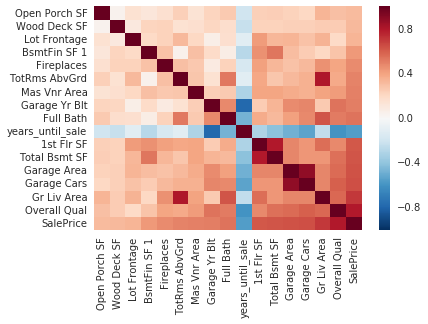

In [50]:
sns.heatmap(num_data.corr())

Garage area and garage cars are well correlated, will drop one.  Will also drop totrooms abvgrd which is highly correlated with Gr Liv Area

In [51]:
cols_to_drop = ['TotRms AbvGrd', 'Garage Cars']
num_data = num_data.drop(cols_to_drop, axis=1)

In [52]:
text_data = transform_text_features(data)

text_data.columns

Index(['Utilities', 'Land Slope', 'BsmtFin Type 1', 'Functional',
       'Garage Finish', 'Fence', 'Paved Drive', 'Exter Qual', 'Exter Cond',
       'Bsmt Qual',
       ...
       'Mo Sold_9', 'Mo Sold_10', 'Mo Sold_11', 'Mo Sold_12',
       'Electrical_FuseA', 'Electrical_FuseF', 'Electrical_FuseP',
       'Electrical_Mix', 'Electrical_No', 'Electrical_SBrkr'],
      dtype='object', length=199)

In [53]:
processed_data = pd.concat([num_data,text_data], axis=1)
processed_data.head()

,Open Porch SF,Wood Deck SF,Lot Frontage,BsmtFin SF 1,Fireplaces,Mas Vnr Area,Garage Yr Blt,Full Bath,years_until_sale,1st Flr SF,Total Bsmt SF,Garage Area,Gr Liv Area,Overall Qual,SalePrice,Utilities,Land Slope,BsmtFin Type 1,Functional,Garage Finish,Fence,Paved Drive,Exter Qual,Exter Cond,Bsmt Qual,Bsmt Cond,Heating QC,Kitchen Qual,Garage Qual,Garage Cond,Pool QC,Fireplace Qu,MS SubClass_20,MS SubClass_30,MS SubClass_40,MS SubClass_45,MS SubClass_50,MS SubClass_60,MS SubClass_70,MS SubClass_75,MS SubClass_80,MS SubClass_85,MS SubClass_90,MS SubClass_120,MS SubClass_150,MS SubClass_160,MS SubClass_180,MS SubClass_190,MS Zoning_A (agr),MS Zoning_C (all),MS Zoning_FV,MS Zoning_I (all),MS Zoning_RH,MS Zoning_RL,MS Zoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_No,Alley_Pave,Lot Shape_IR1,Lot Shape_IR2,Lot Shape_IR3,Lot Shape_Reg,Land Contour_Bnk,Land Contour_HLS,Land Contour_Low,Land Contour_Lvl,Lot Config_Corner,Lot Config_CulDSac,Lot Config_FR2,Lot Config_FR3,Lot Config_Inside,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_Greens,Neighborhood_GrnHill,Neighborhood_IDOTRR,Neighborhood_Landmrk,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition 1_Artery,Condition 1_Feedr,Condition 1_Norm,Condition 1_PosA,Condition 1_PosN,Condition 1_RRAe,Condition 1_RRAn,Condition 1_RRNe,Condition 1_RRNn,Bldg Type_1Fam,Bldg Type_2fmCon,Bldg Type_Duplex,Bldg Type_Twnhs,Bldg Type_TwnhsE,House Style_1.5Fin,House Style_1.5Unf,House Style_1Story,House Style_2.5Fin,House Style_2.5Unf,House Style_2Story,House Style_SFoyer,House Style_SLvl,Roof Style_Flat,Roof Style_Gable,Roof Style_Gambrel,Roof Style_Hip,Roof Style_Mansard,Roof Style_Shed,Roof Matl_ClyTile,Roof Matl_CompShg,Roof Matl_Membran,Roof Matl_Metal,Roof Matl_Roll,Roof Matl_Tar&Grv,Roof Matl_WdShake,Roof Matl_WdShngl,Exterior 1st_AsbShng,Exterior 1st_AsphShn,Exterior 1st_BrkComm,Exterior 1st_BrkFace,Exterior 1st_CBlock,Exterior 1st_CemntBd,Exterior 1st_HdBoard,Exterior 1st_ImStucc,Exterior 1st_MetalSd,Exterior 1st_Plywood,Exterior 1st_PreCast,Exterior 1st_Stone,Exterior 1st_Stucco,Exterior 1st_VinylSd,Exterior 1st_Wd Sdng,Exterior 1st_WdShing,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,Central Air_N,Central Air_Y,Garage Type_2Types,Garage Type_Attchd,Garage Type_Basment,Garage Type_BuiltIn,Garage Type_CarPort,Garage Type_Detchd,Garage Type_No,Misc Feature_Elev,Misc Feature_Gar2,Misc Feature_No,Misc Feature_Othr,Misc Feature_Shed,Misc Feature_TenC,Sale Type_COD,Sale Type_CWD,Sale Type_Con,Sale Type_ConLD,Sale Type_ConLI,Sale Type_ConLw,Sale Type_New,Sale Type_Oth,Sale Type_VWD,Sale Type_WD,Sale Condition_Abnorml,Sale Condition_AdjLand,Sale Condition_Alloca,Sale Condition_Family,Sale Condition_Normal,Sale Condition_Partial,Mo Sold_1,Mo Sold_2,Mo Sold_3,Mo Sold_4,Mo Sold_5,Mo Sold_6,Mo Sold_7,Mo Sold_8,Mo Sold_9,Mo Sold_10,Mo Sold_11,Mo Sold_12,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_No,Electrical_SBrkr
0,62,210,141.0,639.0,2,112.0,1960.0,1,50,1656,1080.0,528.0,1656,6,215000,AllPub,Gtl,BLQ,Typ,Fin,No,P,TA,TA,TA,Gd,Fa,TA,TA,TA,No,Gd,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,140,80.0,468.0,0,0.

In [54]:
processed_data = select_features(processed_data)
rmse = train_and_test(processed_data)

In [55]:
print(rmse)

38557.66333887523


In [56]:
print(train_and_test(data[['Gr Liv Area','SalePrice']]))

57088.25161263909


Using intelligent feature normalization and selection, I was able to decrease RMSE by $20000!

Test kfolds validation:

In [57]:
print(train_and_test(processed_data,k=5))

[31474.522222146512, 37141.00081053823, 32168.056665413922, 28386.83697778513, 27690.09537592331]
31372.10241036142


Using K-folds validation final average RMSE was $31000